In [1]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz



In [2]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)

GraphF_typed (generic function with 5 methods)

# 2. An example of a stratified pure linear model

In [3]:
l_type = @stock_and_flow begin 
    :stocks
    pop
    
    :parameters
    μ
    δ
    rFstOrder
    rage
    
    :dynamic_variables
    v_aging = pop * rage
    v_fstOrder = pop * rFstOrder
    v_birth = N * μ
    v_death = pop * δ
    
    :flows
    pop => f_aging(v_aging) => pop
    pop => f_fstOrder(v_fstOrder) => pop
    CLOUD => f_birth(v_birth) => pop
    pop => f_death(v_death) => CLOUD
    
    :sums
    N = [pop]
    
end

StockAndFlowF with elements S = 1:1, SV = 1:1, LS = 1:1, F = 1:4, I = 1:3, O = 1:3, V = 1:4, LV = 1:3, LSV = 1:1, P = 1:4, LVV = 1:0, LPV = 1:4
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │   pop │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────┐
│ F │ fv │      fname │
├───┼────┼────────────┤
│ 1 │  1 │    f_aging │
│ 2 │  2 │ f_fstOrder │
│ 3 │  3 │    f_birth │
│ 4 │  4 │    f_death │
└───┴────┴────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   4 │  1 │
└───┴─────┴────┘
┌───┬────────────┬─────┐
│ V │      vname │ vop │
├───┼────────────┼─────┤
│ 1 │    v_aging │   * │
│ 2 │ v_fstOrder │   * │
│ 3 │    v_birth │   * │
│ 4 │    v_death │   * │
└───┴────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   1 │   2 │           1 │
│  3 │   1 │   4 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    3 │             1 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────────┐
│ P │     pname │
├───┼───────────┤
│ 1 │         μ │
│ 2 │         δ │
│ 3 │ rFstOrder │
│ 4 │      rage │
└───┴───────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    4 │    1 │            2 │
│   2 │    3 │    2 │            2 │
│   3 │    1 │    3 │            2 │
│   4 │    2 │    4 │            2 │
└─────┴──────┴──────┴──────────────┘

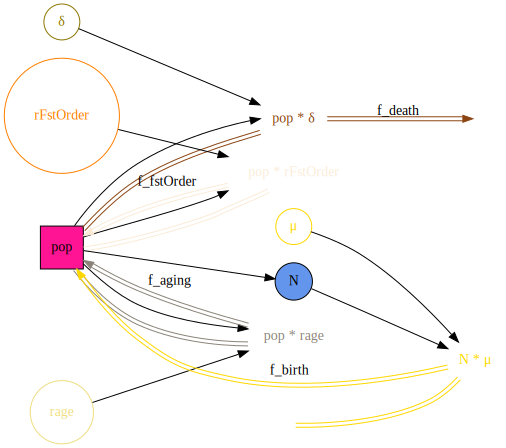

In [4]:
GraphF_typed(id(l_type))

In [5]:
# eliminate the attribute of name to enable pass the natural check
# only eliminate the name, the other two attributes should be okay
l_type = map(l_type, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

In [10]:
s, = parts(l_type, :S)
N, = parts(l_type, :SV)
lsn, = parts(l_type, :LS)
f_aging, f_fstorder, f_birth, f_death = parts(l_type, :F)
i_aging, i_fstorder, i_birth = parts(l_type, :I)
o_aging, o_fstorder, o_death = parts(l_type, :O)
v_aging, v_fstorder, v_birth, v_death = parts(l_type, :V)
lv_aging1, lv_fstorder1, lv_death1 = parts(l_type, :LV)
lsv_birth1, = parts(l_type, :LSV)
p_μ, p_δ, p_rfstOrder, p_rage = parts(l_type, :P)
lpv_aging2, lpv_fstorder2, lpv_birth2, lpv_death2 = parts(l_type, :LPV)

1:4

In [7]:

WeightModel = @stock_and_flow begin
    :stocks
    NormalWeight
    OverWeight
    Obese
    
    :parameters
    μ
    δw
    rw
    ro
    δo
    rage
    
    :dynamic_variables
    v_NewBorn = N * μ
    v_DeathNormalWeight = NormalWeight * δw
    v_BecomingOverWeight = NormalWeight * rw
    v_DeathOverWeight = OverWeight * δw
    v_BecomingObese = OverWeight * ro
    v_DeathObese = Obese * δo
    v_idNW = NormalWeight * rage
    v_idOW = OverWeight * rage
    v_idOb = Obese * rage
    
    :flows
    CLOUD => f_NewBorn(v_NewBorn) => NormalWeight
    NormalWeight => f_DeathNormalWeight(v_DeathNormalWeight) => ClOUD
    NormalWeight => f_BecomingOverWeight(v_BecomingOverWeight) => OverWeight
    OverWeight => f_DeathOverWeight(v_DeathOverWeight) => CLOUD
    
    OverWeight => f_BecomingObese(v_BecomingObese) => Obese
    Obese => f_DeathObese(v_DeathObese) => CLOUD
    NormalWeight => f_idNW(v_idNW) => NormalWeight
    OverWeight => f_idOW(v_idOW) => OverWeight
    Obese => f_idOb(v_idOb) => Obese
    
    :sums
    N = [NormalWeight, OverWeight, Obese]
    
end

StockAndFlowF with elements S = 1:3, SV = 1:1, LS = 1:3, F = 1:9, I = 1:6, O = 1:8, V = 1:9, LV = 1:8, LSV = 1:1, P = 1:6, LVV = 1:0, LPV = 1:9
┌───┬──────────────┐
│ S │        sname │
├───┼──────────────┤
│ 1 │ NormalWeight │
│ 2 │   OverWeight │
│ 3 │        Obese │
└───┴──────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────────────────┐
│ F │ fv │                fname │
├───┼────┼──────────────────────┤
│ 1 │  1 │            f_NewBorn │
│ 2 │  2 │  f_DeathNormalWeight │
│ 3 │  3 │ f_BecomingOverWeight │
│ 4 │  4 │    f_DeathOverWeight │
│ 5 │  5 │      f_BecomingObese │
│ 6 │  6 │         f_DeathObese │
│ 7 │  7 │               f_idNW │
│ 8 │  8 │               f_idOW │
│ 9 │  9 │               f_idOb │
└───┴────┴──────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   7 │  1 │
│ 3 │   3 │  2 │
│ 4 │   8 │  2 │
│ 5 │   5 │  3 │
│ 6 │   9 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   7 │  1 │
│ 4 │   4 │  2 │
│ 5 │   5 │  2 │
│ 6 │   8 │  2 │
│ 7 │   6 │  3 │
│ 8 │   9 │  3 │
└───┴─────┴────┘
┌───┬──────────────────────┬─────┐
│ V │                vname │ vop │
├───┼──────────────────────┼─────┤
│ 1 │            v_NewBorn │   * │
│ 2 │  v_DeathNormalWeight │   * │
│ 3 │ v_BecomingOverWeight │   * │
│ 4 │    v_DeathOverWeight │   * │
│ 5 │      v_BecomingObese │   * │
│ 6 │         v_DeathObese │   * │
│ 7 │               v_idNW │   * │
│ 8 │               v_idOW │   * │
│ 9 │               v_idOb │   * │
└───┴──────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
│  2 │   1 │   3 │           1 │
│  3 │   2 │   4 │           1 │
│  4 │   2 │   5 │           1 │
│  5 │   3 │   6 │           1 │
│  6 │   1 │   7 │           1 │
│  7 │   2 │   8 │           1 │
│  8 │   3 │   9 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             1 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     μ │
│ 2 │    δw │
│ 3 │    rw │
│ 4 │    ro │
│ 5 │    δo │
│ 6 │  rage │
└───┴───────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    2 │    2 │            2 │
│   3 │    3 │    3 │            2 │
│   4 │    2 │    4 │            2 │
│   5 │    4 │    5 │            2 │
│   6 │    5 │    6 │            2 │
│   7 │    6 │    7 │            2 │
│   8 │    6 │    8 │            2 │
│   9 │    6 │    9 │            2 │
└─────┴──────┴──────┴──────────────┘

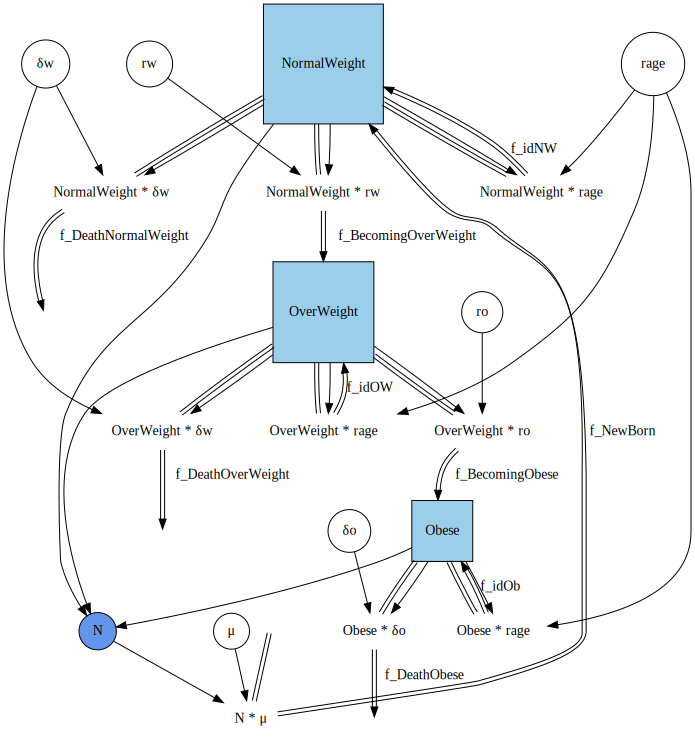

In [8]:
GraphF(WeightModel, rd="TB")

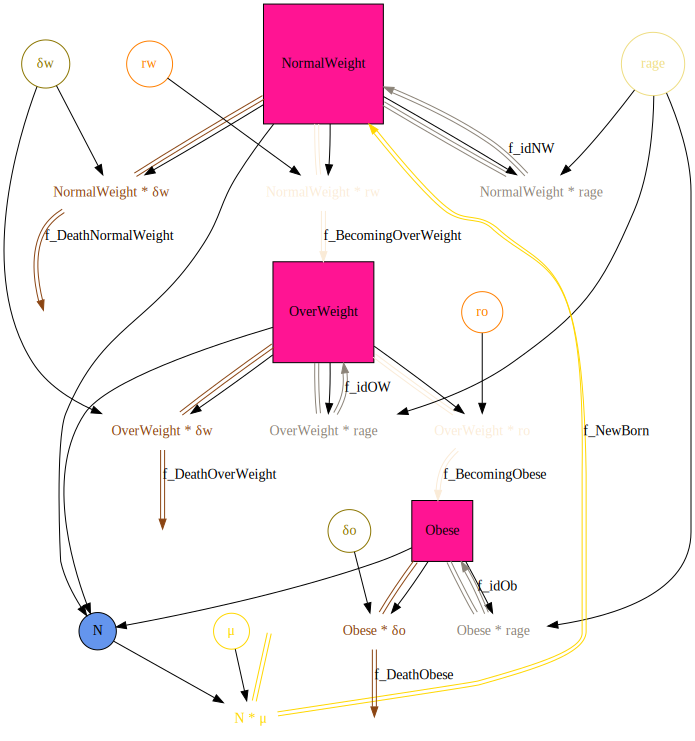

In [11]:
typed_WeightModel=ACSetTransformation(WeightModel, l_type,
  S = [s,s,s],
  SV = [N],
  LS = [lsn,lsn,lsn],   
  F = [f_birth, f_death, f_fstorder, f_death, f_fstorder, f_death, f_aging, f_aging, f_aging],    
  I = [i_birth, i_aging, i_fstorder, i_aging, i_fstorder, i_aging], 
  O = [o_death, o_fstorder, o_aging, o_death, o_fstorder, o_aging, o_death, o_aging],
  V = [v_birth, v_death, v_fstorder, v_death, v_fstorder, v_death, v_aging, v_aging, v_aging],
  LV = [lv_death1, lv_fstorder1, lv_death1, lv_fstorder1, lv_death1, lv_aging1, lv_aging1, lv_aging1],
  LSV = [lsv_birth1],
  P = [p_μ, p_δ, p_rfstOrder, p_rfstOrder, p_δ, p_rage],
  LPV = [lpv_birth2, lpv_death2, lpv_fstorder2, lpv_death2, lpv_fstorder2, lpv_death2, lpv_aging2, lpv_aging2, lpv_aging2],
  Name = name -> nothing, Op=op->nothing, Position=pos->nothing
);
@assert is_natural(typed_WeightModel)
GraphF_typed(typed_WeightModel, rd="TB")

In [12]:
ageWeightModel = @stock_and_flow begin
    :stocks
    Child
    Adult
    Senior
    
    :parameters
    μ
    δC
    δA
    δS
    rageCA
    rageAS
    r
    
    :dynamic_variables
    v_NB = N * μ
    v_DeathC = Child * δC
    v_idC = Child * r
    v_agingCA = Child * rageCA
    v_DeathA = Adult * δA
    v_idA = Adult * r
    v_agingAS = Adult * rageAS
    v_DeathS = Senior * δS
    v_idS = Senior * r
    
    :flows
    CLOUD => f_NB(v_NB) => Child
    Child => f_idC(v_idC) => Child
    Child => f_DeathC(v_DeathC) => CLOUD
    Child => f_agingCA(v_agingCA) => Adult
    Adult => f_idA(v_idA) => Adult
    Adult => f_DeathA(v_DeathA) => CLOUD
    Adult => f_agingAS(v_agingAS) => Senior
    Senior => f_idS(v_idS) => Senior
    Senior => v_DeathS(v_DeathS) => CLOUD
    
    :sums
    N = [Child, Adult, Senior]
    
    
end


StockAndFlowF with elements S = 1:3, SV = 1:1, LS = 1:3, F = 1:9, I = 1:6, O = 1:8, V = 1:9, LV = 1:8, LSV = 1:1, P = 1:7, LVV = 1:0, LPV = 1:9
┌───┬────────┐
│ S │  sname │
├───┼────────┤
│ 1 │  Child │
│ 2 │  Adult │
│ 3 │ Senior │
└───┴────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬───────────┐
│ F │ fv │     fname │
├───┼────┼───────────┤
│ 1 │  1 │      f_NB │
│ 2 │  3 │     f_idC │
│ 3 │  2 │  f_DeathC │
│ 4 │  4 │ f_agingCA │
│ 5 │  6 │     f_idA │
│ 6 │  5 │  f_DeathA │
│ 7 │  7 │ f_agingAS │
│ 8 │  9 │     f_idS │
│ 9 │  8 │  v_DeathS │
└───┴────┴───────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   4 │  2 │
│ 4 │   5 │  2 │
│ 5 │   7 │  3 │
│ 6 │   8 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   4 │  1 │
│ 4 │   5 │  2 │
│ 5 │   6 │  2 │
│ 6 │   7 │  2 │
│ 7 │   8 │  3 │
│ 8 │   9 │  3 │
└───┴─────┴────┘
┌───┬───────────┬─────┐
│ V │     vname │ vop │
├───┼───────────┼─────┤
│ 1 │      v_NB │   * │
│ 2 │  v_DeathC │   * │
│ 3 │     v_idC │   * │
│ 4 │ v_agingCA │   * │
│ 5 │  v_DeathA │   * │
│ 6 │     v_idA │   * │
│ 7 │ v_agingAS │   * │
│ 8 │  v_DeathS │   * │
│ 9 │     v_idS │   * │
└───┴───────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
│  2 │   1 │   3 │           1 │
│  3 │   1 │   4 │           1 │
│  4 │   2 │   5 │           1 │
│  5 │   2 │   6 │           1 │
│  6 │   2 │   7 │           1 │
│  7 │   3 │   8 │           1 │
│  8 │   3 │   9 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             1 │
└─────┴───────┴──────┴───────────────┘
┌───┬────────┐
│ P │  pname │
├───┼────────┤
│ 1 │      μ │
│ 2 │     δC │
│ 3 │     δA │
│ 4 │     δS │
│ 5 │ rageCA │
│ 6 │ rageAS │
│ 7 │      r │
└───┴────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    2 │    2 │            2 │
│   3 │    7 │    3 │            2 │
│   4 │    5 │    4 │            2 │
│   5 │    3 │    5 │            2 │
│   6 │    7 │    6 │            2 │
│   7 │    6 │    7 │            2 │
│   8 │    4 │    8 │            2 │
│   9 │    7 │    9 │            2 │
└─────┴──────┴──────┴──────────────┘

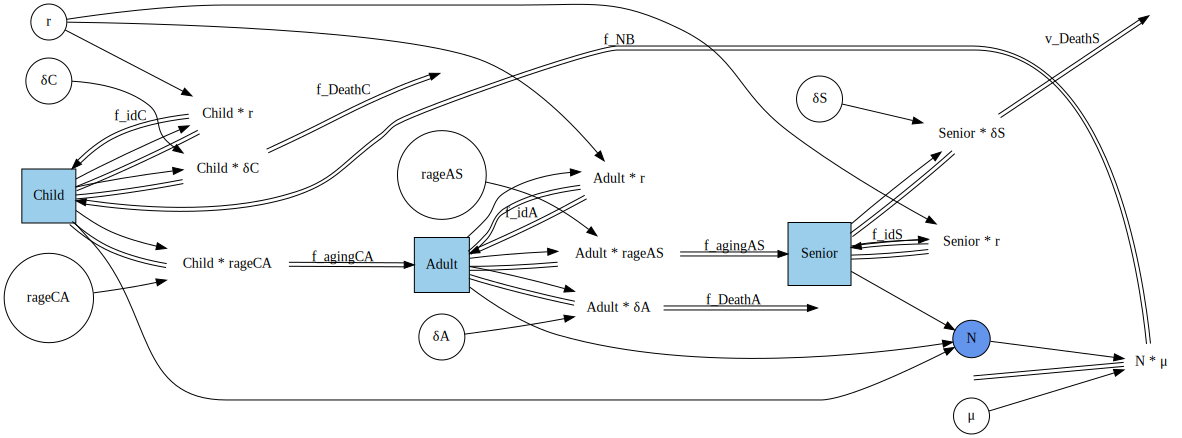

In [13]:
GraphF(ageWeightModel)

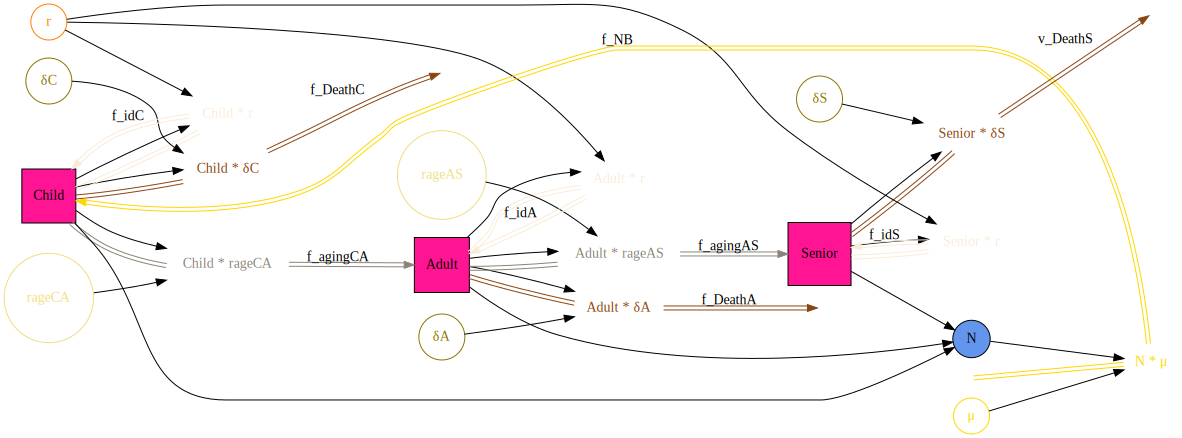

In [14]:
typed_ageWeightModel=ACSetTransformation(ageWeightModel, l_type,
  S = [s,s,s],
  SV = [N],
  LS = [lsn,lsn,lsn],   
  F = [f_birth, f_fstorder, f_death, f_aging, f_fstorder, f_death, f_aging, f_fstorder, f_death],    
  I = [i_birth, i_fstorder, i_aging, i_fstorder, i_aging, i_fstorder], 
O = [o_fstorder, o_death, o_aging, o_fstorder, o_death, o_aging, o_fstorder, o_death],
V = [v_birth, v_death, v_fstorder, v_aging, v_death, v_fstorder, v_aging, v_death, v_fstorder],
  LV = [lv_death1, lv_fstorder1, lv_aging1, lv_death1, lv_fstorder1, lv_aging1, lv_death1, lv_fstorder1],
  LSV = [lsv_birth1],
  P = [p_μ, p_δ, p_δ, p_δ, p_rage, p_rage, p_rfstOrder],
  LPV = [lpv_birth2, lpv_death2, lpv_fstorder2, lpv_aging2, lpv_death2, lpv_fstorder2, lpv_aging2, lpv_death2, lpv_fstorder2],
  Name = name -> nothing, Op=op->nothing, Position=pos->nothing
);
@assert is_natural(typed_ageWeightModel)
GraphF_typed(typed_ageWeightModel)

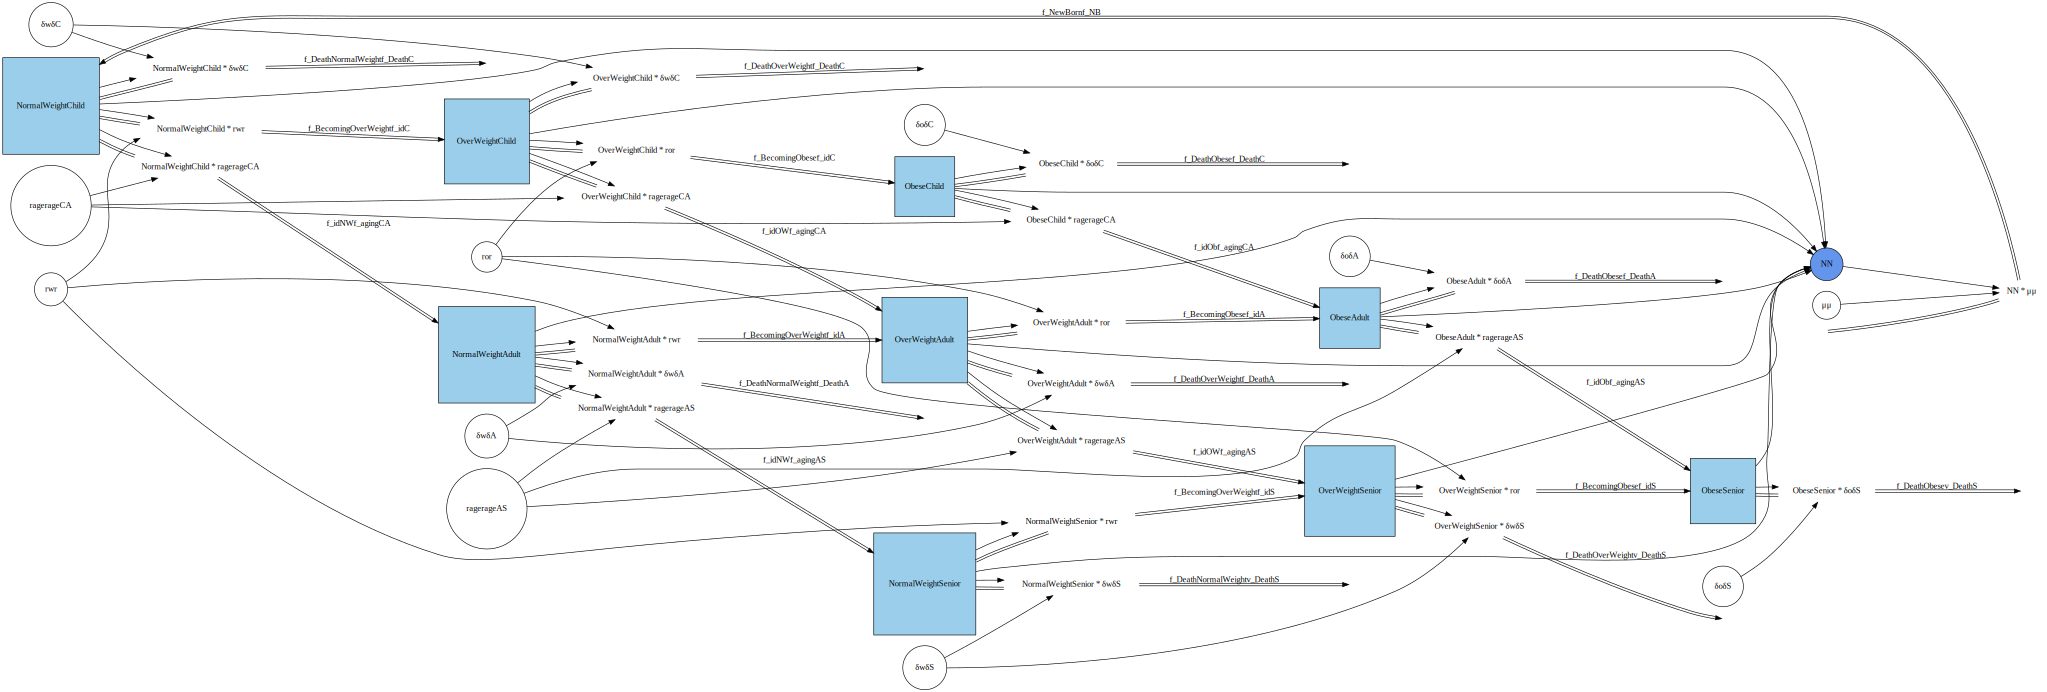

In [15]:
aged_weight = pullback(typed_WeightModel, typed_ageWeightModel) |> apex |> rebuildStratifiedModelByFlattenSymbols;
GraphF(aged_weight)

In [16]:
p_weight = LVector(
    μμ=12.5/1000,δwδC=2.0/1000,δoδC=8.0/1000,δwδA=4.0/1000,δoδA=13.0/1000,δwδS=8.0/1000,δoδS=30.0/1000,
    ragerageCA=1.0/(12.0*365.0),ragerageAS=1.0/(50.0*365.0),rwr=0.03,ror=0.06
)

u0_weight = LVector(
    NormalWeightChild=95811.0*12.0/82.0, OverWeightChild=27709.0*12.0/82.0, ObeseChild=30770.0*12.0/82.0,
    NormalWeightAdult=95811.0*50.0/82.0, OverWeightAdult=27709.0*50.0/82.0, ObeseAdult=30770.0*50.0/82.0,
    NormalWeightSenior=95811.0*20.0/82.0, OverWeightSenior=27709.0*20.0/82.0, ObeseSenior=30770.0*20.0/82.0
);

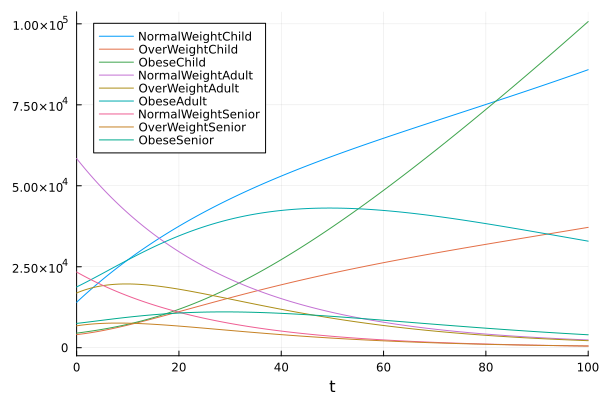

In [17]:
prob_stratified_weight = ODEProblem(vectorfield(aged_weight),u0_weight,(0.0,100.0),p_weight);
sol_stratified_weight = solve(prob_stratified_weight,Tsit5(),abstol=1e-8);
plot(sol_stratified_weight)

In [18]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")